# procesando un chingo de la idioma natural

In [66]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
# NLP Tools
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy as sp
from textblob import TextBlob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(42)

### Load Data

In [2]:
bb = pd.read_csv('./jun20_bb_posts.csv', )
cnn = pd.read_csv('./jun20_cnn_posts.csv')
fox = pd.read_csv('./jun20_fox_posts.csv')
fox2 = pd.read_csv('./fox_posts_jun26.csv')
fox3 = pd.read_csv('./fox_posts_jun29.csv')
nr = pd.read_csv('./jun20_nr_posts.csv')
nr2 = pd.read_csv('./jun29_nr_posts.csv')
# nyt = pd.read_csv('./jun20_nyt_posts.csv')
vice = pd.read_csv('./jun20_vice_posts.csv')
dem = pd.read_csv('./jun21_demnow_posts.csv')
dem2 = pd.read_csv('./jun22_demnow_posts.csv')
dem3 = pd.read_csv('./jun23_demnow_posts.csv')
dem4 = pd.read_csv('./jun24_demnow_posts.csv')
dem5 = pd.read_csv('./jun25_demnow_posts.csv')
dem6 = pd.read_csv('./jun26_demnow_posts.csv')
dem7 = pd.read_csv('./jun29_demnow_posts.csv')
inwa = pd.read_csv('./june20infowars.csv')
inwa2 = pd.read_csv('./june21infowars.csv')
inwa3 = pd.read_csv('./june22infowars.csv')
inwa4 = pd.read_csv('./june23infowars.csv')
inwa5 = pd.read_csv('./june24infowars.csv')
inwa6 = pd.read_csv('./june25infowars.csv')
inwa7 = pd.read_csv('./june26infowars.csv')
inwa8 = pd.read_csv('./june29infowars.csv')
msnbc = pd.read_csv('./jun26_msnbc_posts.csv')
huff = pd.read_csv('./jun_24_huff_posts.csv')

In [3]:
bb['yes_right'] = 1
cnn['yes_right'] = 0
fox['yes_right'] = 1
fox2['yes_right'] = 1
fox3['yes_right'] = 1
nr['yes_right'] = 1
nr2['yes_right'] = 1
# nyt['yes_right'] = 0
vice['yes_right'] = 0
dem['yes_right'] = 0
dem2['yes_right'] = 0
dem3['yes_right'] = 0
dem4['yes_right'] = 0
dem5['yes_right'] = 0
dem6['yes_right'] = 0
dem7['yes_right'] = 0
inwa['yes_right'] = 1
inwa2['yes_right'] = 1
inwa3['yes_right'] = 1
inwa4['yes_right'] = 1
inwa5['yes_right'] = 1
inwa6['yes_right'] = 1
inwa7['yes_right'] = 1
inwa8['yes_right'] = 1
msnbc['yes_right'] = 0
huff['yes_right'] = 0

In [4]:
text = pd.concat(
    [bb, cnn, fox, fox2, fox3, nr, nr2, vice, dem, dem2, dem3, dem4, dem5, dem6, dem7, inwa,
     inwa2, inwa3, inwa4, inwa5, inwa6, inwa7, inwa8, msnbc, huff])

### Clean Data

In [5]:
text.drop(['Unnamed: 0', 'category', 'urlToImage'], axis=1, inplace=True)

In [6]:
text.isna().sum()

author         9466
description      69
publishedAt       0
source            0
title             1
url               0
yes_right         0
dtype: int64

In [7]:
no_desc = text.description.isna()

In [8]:
text.dropna(subset=['description','title'], inplace=True)

In [9]:
text.isna().sum()

author         9408
description       0
publishedAt       0
source            0
title             0
url               0
yes_right         0
dtype: int64

In [10]:
text.fillna('no_author', inplace=True)

In [11]:
text.shape

(50578, 7)

In [12]:
len(text.url.unique())

36854

In [13]:
text.drop_duplicates('url', inplace=True)

In [14]:
text.isna().sum().sum()

0

In [15]:
text.shape

(36854, 7)

In [16]:
text.reset_index(drop=True, inplace=True)

In [68]:
text.yes_right.value_counts()[1]/len(text.yes_right) #baseline

0.4652954903131275

In [18]:
text.source.value_counts()

fox news           6381
national review    5348
huffington post    4950
msnbc              4950
vice news          4949
breitbart          4948
cnn                4776
infowars            471
democracy now        81
Name: source, dtype: int64

In [19]:
source_dict = {'breitbart': "Breitbart", 'cnn': "CNN", 'fox news': "Fox News",
               'national review': "National Review", 'vice news': "Vice News", 'democracy now': "Democracy Now",
               'infowars': "Infowars", 'msnbc': "MSNBC", 'huffington post': "Huffington Post"}

text['source'] = text['source'].map(source_dict)

In [20]:
for row in text.values:
    author = row[0]
    source = row[3]
    row[1] = row[1].replace(author, '')
    row[1] = row[1].replace(source, '')
    row[1] = row[1].replace(author.lower(), '')
    row[1] = row[1].replace(source.lower(), '')
    row[4] = row[1].replace(author, '')
    row[4] = row[1].replace(source, '')
    row[4] = row[1].replace(author.lower(), '')
    row[4] = row[1].replace(source.lower(), '')    

## Feature Engineering

In [21]:
text['combined'] = text.title + ' ' + text.description # all text together

#### Sentiment Analysis

In [22]:
# text['title_length'] = [len(n) for n in text['title']] # just character length

In [23]:
# text['title_word_count'] = [len(TextBlob(w).words) for w in text.title]

In [24]:
# text['title_avg_w_len'] = text.title_length/text.title_word_count

In [25]:
text['title_polarity'] = [TextBlob(w).sentiment.polarity for w in text.title]

In [26]:
text['title_subjectivity'] = [TextBlob(w).sentiment.subjectivity for w in text.title]

In [27]:
text['desc_polarity'] = [TextBlob(w).sentiment.polarity for w in text.description]

In [28]:
text['desc_subjectivity'] = [TextBlob(w).sentiment.subjectivity for w in text.description]

In [29]:
text['title_polarity'] = (text.title_polarity - min(text.title_polarity))/(max(text.title_polarity)-min(text.title_polarity))
text['desc_polarity'] = (text.desc_polarity - min(text.desc_polarity))/(max(text.desc_polarity)-min(text.desc_polarity))
# manual minmax scaler; i do not want negative values 

In [30]:
text['subj_difference'] = text['title_subjectivity'] - text['desc_subjectivity']
text['polarity_difference']  = text['title_polarity'] - text['desc_polarity']

#### Parts of Speech Tagging

In [31]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [32]:
title_tags = [TextBlob(w.lower(), tokenizer=tokenizer).tags for w in text.title]

In [33]:
title_tags[0]

[('peter', 'NN'),
 ('fonda', 'NN'),
 ('lying', 'VBG'),
 ('gash', 'JJ'),
 ('kirstjen', 'NNS'),
 ('nielsen', 'VBN'),
 ('should', 'MD'),
 ('be', 'VB'),
 ('whipped', 'VBN'),
 ('naked', 'JJ'),
 ('in', 'IN'),
 ('public', 'JJ')]

In [34]:
tags_counts = []
for row in title_tags:
    tags = [n[1] for n in row]
    tags_counts.append(tags)

In [35]:
title_parts_of_speech = []
for n in tags_counts:
    foo = dict(pd.Series(n).value_counts(normalize=True))
    title_parts_of_speech.append(foo)

In [36]:
title_parts_of_speech = pd.DataFrame(title_parts_of_speech).fillna(0)

In [37]:
title_parts_of_speech.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,MD,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.250000,0.0,0.0,0.083333,...,0.083333,0.0,0.083333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.083333,0.250000,0.0,0.0,0.083333,...,0.083333,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.363636,0.0,0.0,0.000000,...,0.090909,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.125000,0.125000,0.0,0.0,0.000000,...,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.090909,0.0,0.0,0.272727,0.090909,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
sorted([title_parts_of_speech[col].sum() for col in title_parts_of_speech.columns])[:10]
# Any columns with negligible values?

[0.14285714285714285,
 0.29642857142857143,
 1.4419413919413919,
 1.7037360300518194,
 4.5128791959674306,
 9.5963090830737876,
 12.561901677613751,
 12.975215367707627,
 21.887959024120015,
 26.311972851087564]

In [39]:
title_parts_of_speech.columns = [str(n) + '_title' for n in title_parts_of_speech.columns]

In [40]:
title_parts_of_speech.describe().T.sort_values('mean', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
NN_title,36854.0,0.344309,0.161561,0.0,0.230769,0.333333,0.444444,1.000000
JJ_title,36854.0,0.120518,0.104608,0.0,0.000000,0.111111,0.181818,1.000000
IN_title,36854.0,0.096176,0.079306,0.0,0.000000,0.100000,0.142857,0.666667
NNS_title,36854.0,0.094811,0.099862,0.0,0.000000,0.083333,0.142857,1.000000
DT_title,36854.0,0.045403,0.070085,0.0,0.000000,0.000000,0.090909,0.500000


In [41]:
desc_tags = [TextBlob(w, tokenizer=tokenizer).tags for w in text.description]

In [42]:
tags_counts = []
for row in desc_tags:
    tags = [n[1] for n in row]
    tags_counts.append(tags)

In [43]:
desc_parts_of_speech = []
for n in tags_counts:
    foo = dict(pd.Series(n).value_counts(normalize=True))
    desc_parts_of_speech.append(foo)

In [44]:
desc_parts_of_speech = pd.DataFrame(desc_parts_of_speech).fillna(0)

In [45]:
desc_parts_of_speech.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.000000,0.0,0.068182,0.0,0.0,0.090909,0.022727,0.0,0.000000,0.0,...,0.022727,0.068182,0.045455,0.022727,0.000000,0.000000,0.0,0.022727,0.0,0.0
1,0.040000,0.0,0.000000,0.0,0.0,0.080000,0.080000,0.0,0.000000,0.0,...,0.000000,0.000000,0.160000,0.040000,0.000000,0.040000,0.0,0.000000,0.0,0.0
2,0.040000,0.0,0.120000,0.0,0.0,0.100000,0.060000,0.0,0.000000,0.0,...,0.080000,0.020000,0.060000,0.020000,0.100000,0.040000,0.0,0.000000,0.0,0.0
3,0.034483,0.0,0.103448,0.0,0.0,0.103448,0.137931,0.0,0.000000,0.0,...,0.068966,0.034483,0.068966,0.000000,0.000000,0.034483,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.085714,0.0,0.0,0.114286,0.114286,0.0,0.028571,0.0,...,0.000000,0.028571,0.057143,0.028571,0.057143,0.000000,0.0,0.000000,0.0,0.0


In [46]:
desc_parts_of_speech.columns = [str(n) + '_desc' for n in desc_parts_of_speech.columns]

In [47]:
desc_parts_of_speech.shape[0] == title_parts_of_speech.shape[0]

True

In [48]:
pos_tags = pd.concat([title_parts_of_speech, desc_parts_of_speech], axis=1)

In [49]:
text.columns

Index(['author', 'description', 'publishedAt', 'source', 'title', 'url',
       'yes_right', 'combined', 'title_polarity', 'title_subjectivity',
       'desc_polarity', 'desc_subjectivity', 'subj_difference',
       'polarity_difference'],
      dtype='object')

In [50]:
df = pd.concat([text[['title_polarity', 'title_subjectivity', 'desc_polarity', 'desc_subjectivity', 
                      'subj_difference', 'polarity_difference']], pos_tags, text.yes_right], axis=1)
df.head(3)

,title_polarity,title_subjectivity,desc_polarity,desc_subjectivity,subj_difference,polarity_difference,CC_title,CD_title,DT_title,EX_title,...,VBD_desc,VBG_desc,VBN_desc,VBP_desc,VBZ_desc,WDT_desc,WP_desc,WP$_desc,WRB_desc,yes_right
0,0.50,0.233333,0.500000,0.000000,0.233333,0.000000,0.0,0.0,0.0,0.0,...,0.068182,0.045455,0.022727,0.0,0.00,0.0,0.022727,0.0,0.0,1
1,0.25,0.900000,0.250000,0.650000,0.250000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.160000,0.040000,0.0,0.04,0.0,0.000000,0.0,0.0,1
2,0.40,0.300000,0.555417,0.666667,-0.366667,-0.155417,0.0,0.0,0.0,0.0,...,0.020000,0.060000,0.020000,0.1,0.04,0.0,0.000000,0.0,0.0,1


In [51]:
def scaled_checker(df):
    for col in df.columns:
        if max(df[col]) > 1:
            print(col)
        if min(df[col]) < 0:
            print(col)
        else:
            pass
        
scaled_checker(df)

subj_difference
polarity_difference


In [52]:
df[['subj_difference','polarity_difference']].describe().T

,count,mean,std,min,25%,50%,75%,max
subj_difference,36854.0,-0.094586,0.383313,-1.0,-0.350000,-0.041667,0.065054,1.0
polarity_difference,36854.0,-0.015985,0.147947,-1.0,-0.083333,0.000000,0.038194,0.9


In [53]:
df['subj_difference'] = (df['subj_difference'] - min(df['subj_difference']))/(max(df['subj_difference'])-min(df['subj_difference']))
df['polarity_difference'] = (df['polarity_difference'] - min(df['polarity_difference']))/(max(df['polarity_difference'])-min(df['polarity_difference']))


In [54]:
scaled_checker(df) # numerical data is scaled

# Explorin

> Note: some of these CountVect instances have a tokenizer, some don't

In [190]:
rightwing = df[df.yes_right==1]
notrightwing = df[df.yes_right==0]

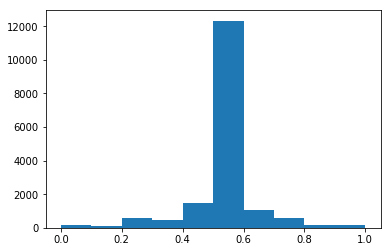

In [193]:
plt.hist(rightwing.title_polarity);

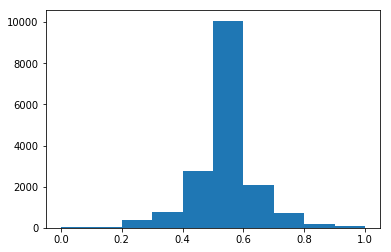

In [194]:
plt.hist(rightwing.desc_polarity);

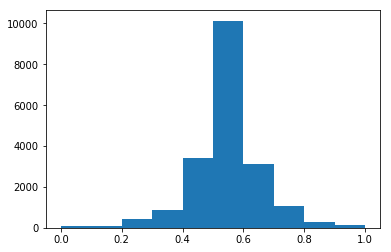

In [80]:
plt.hist(notrightwing.polarity);

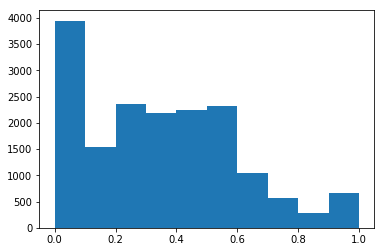

In [82]:
plt.hist(rightwing.subjectivity);

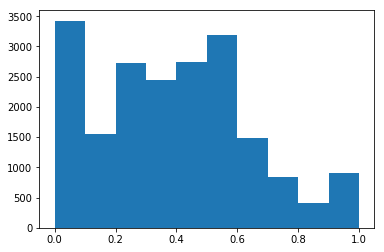

In [83]:
plt.hist(notrightwing.subjectivity);

In [195]:
rightwing.describe()

,title_polarity,title_subjectivity,desc_polarity,desc_subjectivity,subj_difference,polarity_difference,CC_title,CD_title,DT_title,EX_title,...,VBD_desc,VBG_desc,VBN_desc,VBP_desc,VBZ_desc,WDT_desc,WP_desc,WP$_desc,WRB_desc,yes_right
count,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,...,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.0
mean,0.507856,0.201348,0.524753,0.312785,0.444282,0.517423,0.008432,0.022978,0.038060,0.000310,...,0.034257,0.024705,0.020803,0.014852,0.029732,0.002963,0.003808,0.000142,0.002923,1.0
std,0.113371,0.296501,0.107291,0.270642,0.180273,0.070814,0.032427,0.064051,0.070437,0.005626,...,0.039131,0.033099,0.031306,0.028934,0.038369,0.010380,0.012822,0.002227,0.012765,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.500000,0.000000,0.500000,0.000000,0.325000,0.488722,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.500000,0.000000,0.500000,0.300000,0.478975,0.526316,0.000000,0.000000,0.000000,0.000000,...,0.026316,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.500000,0.400000,0.568182,0.500000,0.500000,0.539474,0.000000,0.000000,0.071429,0.000000,...,0.058824,0.043478,0.037037,0.023810,0.047619,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.500000,0.200000,...,0.500000,0.333333,0.333333,0.400000,0.333333,0.142857,0.200000,0.071429,0.333333,1.0


In [196]:
notrightwing.describe()

,title_polarity,title_subjectivity,desc_polarity,desc_subjectivity,subj_difference,polarity_difference,CC_title,CD_title,DT_title,EX_title,...,VBD_desc,VBG_desc,VBN_desc,VBP_desc,VBZ_desc,WDT_desc,WP_desc,WP$_desc,WRB_desc,yes_right
count,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,...,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.000000,19706.0
mean,0.520245,0.252814,0.535436,0.332736,0.460039,0.518320,0.010126,0.029525,0.051793,0.000368,...,0.036111,0.024497,0.018485,0.019779,0.034302,0.002931,0.004942,0.000086,0.004543,0.0
std,0.124798,0.315929,0.117447,0.284190,0.200756,0.083520,0.029949,0.091624,0.069148,0.005880,...,0.045032,0.035787,0.032652,0.037831,0.041853,0.011350,0.017139,0.001955,0.016730,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.500000,0.000000,0.500000,0.000000,0.325000,0.479665,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.500000,0.050000,0.500000,0.316369,0.479167,0.526316,0.000000,0.000000,0.000000,0.000000,...,0.024390,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.550000,0.487500,0.587500,0.500000,0.555556,0.552632,0.000000,0.000000,0.100000,0.000000,...,0.062500,0.044444,0.033333,0.032258,0.058824,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.960526,0.250000,0.750000,0.500000,0.166667,...,0.500000,0.666667,0.500000,0.428571,0.333333,0.142857,0.500000,0.100000,0.500000,0.0


### Single Grams for Title

In [198]:
right = text['yes_right'] == 1
notright = text['yes_right'] == 0

In [199]:
right_title = text[right].title
right_desc = text[right].description
notright_title = text[notright].title
notright_desc = text[notright].description

In [99]:
stem = PorterStemmer()
cvec = CountVectorizer(preprocessor=stem.stem, tokenizer=tokenizer.tokenize, ngram_range=(1,1), stop_words='english', min_df=10)

In [207]:
cvec.fit(right_title)
rt_counts = pd.DataFrame(cvec.transform(right_title).todense(),
                       columns=cvec.get_feature_names())
title_counts = rt_counts.sum(axis=0)
title_counts = pd.DataFrame(title_counts.sort_values(ascending = False), columns=['right'])

In [208]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(1,1), stop_words='english', min_df=10)
cvec.fit(notright_title)
nrt_counts = pd.DataFrame(cvec.transform(notright_title).todense(),
                         columns=cvec.get_feature_names())
nrt_counts = nrt_counts.sum(axis=0)
title_counts['not right'] = nrt_counts

In [209]:
title_counts.head(20)

,right,not right
s,3221,NaN
trump,2983,3873.0
new,1503,1079.0
fox,1062,95.0
t,602,NaN
report,578,293.0
north,523,414.0
korea,503,401.0
says,424,492.0
u,399,NaN


In [210]:
title_counts.sort_values('not right', ascending=False).head(20)

,right,not right
trump,2983,3873.0
new,1503,1079.0
says,424,492.0
2018,220,430.0
house,352,425.0
north,523,414.0
korea,503,401.0
cohen,53,391.0
white,301,348.0
kim,397,347.0


### Single Grams for Description

In [211]:
cvec = CountVectorizer(preprocessor=stem.stem, tokenizer=tokenizer.tokenize, ngram_range=(1,1), stop_words='english', min_df=10)
cvec.fit(right_desc)
rd_counts = pd.DataFrame(cvec.transform(right_desc).todense(),
                         columns=cvec.get_feature_names())
desc_counts = rd_counts.sum(axis=0)
desc_counts = pd.DataFrame(desc_counts.sort_values(ascending = False), columns=['right'])

In [146]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(1,1), stop_words='english', min_df=10)
cvec.fit(notright_desc)
nrd_counts = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrd_counts = nrd_counts.sum(axis=0)
desc_counts['not right'] = nrd_counts

In [147]:
desc_counts.head(20)

,right,not right
trump,3830,4756.0
president,3215,2796.0
news,3121,857.0
fox,2794,180.0
new,1480,2052.0
house,1214,1033.0
said,1205,1093.0
donald,1111,1374.0
north,938,721.0
state,909,527.0


In [148]:
desc_counts.sort_values('not right', ascending=False).head(20)

,right,not right
trump,3830,4756.0
president,3215,2796.0
new,1480,2052.0
donald,1111,1374.0
said,1205,1093.0
house,1214,1033.0
cnn,192,958.0
news,3121,857.0
says,843,838.0
people,632,830.0


### BiGrams for Title

In [149]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(2,2), stop_words='english', min_df=10)
cvec.fit(right_title)
rt_counts2 = pd.DataFrame(cvec.transform(right_title).todense(),
                         columns=cvec.get_feature_names())
title_counts2 = rt_counts2.sum(axis=0)
title_counts2 = pd.DataFrame(title_counts2.sort_values(ascending = False), columns=['right'])

In [150]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(2,2), stop_words='english', min_df=10)
cvec.fit(notright_title)
nrt_counts2 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrt_counts2 = nrt_counts2.sum(axis=0)
title_counts2['not right'] = nrt_counts2

In [151]:
title_counts2.head(15)

,right,not right
fox new,961,NaN
north korea,417,386.0
donald trump,303,1352.0
kim jong,182,414.0
white house,181,634.0
president trump,181,904.0
ig report,141,7.0
supreme court,129,94.0
trump kim,121,61.0
judicial activism,104,NaN


In [152]:
title_counts2.sort_values('not right', ascending=False).head(15)

,right,not right
donald trump,303,1352.0
president trump,181,904.0
white house,181,634.0
new york,100,420.0
kim jong,182,414.0
michael cohen,25,405.0
trump administration,67,400.0
north korea,417,386.0
north korean,54,254.0
special counsel,28,236.0


### BiGrams for Description

In [153]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(2,2), stop_words='english', min_df=10)
cvec.fit(right_desc)
rd_counts2 = pd.DataFrame(cvec.transform(right_desc).todense(),
                         columns=cvec.get_feature_names())
desc_counts2 = rd_counts2.sum(axis=0)
desc_counts2 = pd.DataFrame(desc_counts2.sort_values(ascending = False), columns=['right'])

In [154]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(2,2), stop_words='english', min_df=10)
cvec.fit(notright_desc)
nrd_counts2 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrd_counts2 = nrd_counts2.sum(axis=0)
desc_counts2['not right'] = nrd_counts2

In [155]:
desc_counts2.head(15)

,right,not right
fox news,2463,101.0
president trump,1187,904.0
donald trump,1088,1352.0
president donald,932,673.0
white house,621,634.0
new york,481,420.0
kim jong,474,414.0
north korea,473,386.0
year old,339,201.0
united states,314,223.0


In [156]:
desc_counts2.sort_values('not right',ascending=False).head(15)

,right,not right
donald trump,1088,1352.0
president trump,1187,904.0
president donald,932,673.0
white house,621,634.0
new york,481,420.0
kim jong,474,414.0
michael cohen,45,405.0
trump administration,257,400.0
north korea,473,386.0
north korean,313,254.0


### TriGrams for Title

In [157]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(3,3), stop_words='english', min_df=5)
cvec.fit(right_title)
rt_counts3 = pd.DataFrame(cvec.transform(right_title).todense(),
                         columns=cvec.get_feature_names())
title_counts3 = rt_counts3.sum(axis=0)
title_counts3 = pd.DataFrame(title_counts3.sort_values(ascending = False), columns=['right'])

In [158]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(3,3), stop_words='english', min_df=5)
cvec.fit(notright_title)
nrt_counts3 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrt_counts3 = nrt_counts3.sum(axis=0)
title_counts3['not right'] = nrt_counts3

In [159]:
title_counts3.head(15)

,right,not right
liberal judicial activism,104,NaN
day liberal judicial,104,NaN
north korea summit,76,38.0
trump kim summit,66,8.0
say fox new,53,NaN
says fox new,37,NaN
police say fox,34,NaN
report fox new,29,NaN
fox news rundown,27,NaN
south china sea,26,13.0


In [160]:
title_counts3.sort_values('not right', ascending=False).head(15)

,right,not right
new york times,23,155.0
new york city,7,60.0
trump legal team,5,48.0
summit north korea,5,42.0
trump kim jong,23,41.0
trump white house,8,41.0
fe high school,7,39.0
santa fe high,9,38.0
north korea summit,76,38.0
donald trump jr,14,34.0


### TriGrams for Description

In [161]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(3,3), stop_words='english', min_df=5)
cvec.fit(right_desc)
rd_counts3 = pd.DataFrame(cvec.transform(right_desc).todense(),
                         columns=cvec.get_feature_names())
desc_counts3 = rd_counts3.sum(axis=0)
desc_counts3 = pd.DataFrame(desc_counts3.sort_values(ascending = False), columns=['right'])

In [162]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(3,3), stop_words='english', min_df=5)
cvec.fit(notright_desc)
nrd_counts3 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrd_counts3 = nrd_counts3.sum(axis=0)
desc_counts3['not right'] = nrd_counts3

In [163]:
desc_counts3.head(15)

,right,not right
president donald trump,926,672.0
nationalreview com wp,238,NaN
com www nationalreview,238,NaN
wp com www,238,NaN
com wp content,238,NaN
wp content uploads,238,NaN
www nationalreview com,238,NaN
content uploads 2018,233,NaN
jpg fit 1024,218,NaN
1024 2c597 ssl,216,NaN


In [164]:
desc_counts3.sort_values('not right',ascending=False).head(15)

,right,not right
president donald trump,926,672.0
north korean leader,102,158.0
new york times,118,155.0
leader kim jong,108,149.0
korean leader kim,91,133.0
special counsel robert,110,125.0
counsel robert mueller,108,122.0
fbi director james,60,81.0
director james comey,59,81.0
lawyer michael cohen,15,69.0


### QuadGrams for Title

In [165]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(4,4), stop_words='english', min_df=3)
cvec.fit(right_title)
rt_counts4 = pd.DataFrame(cvec.transform(right_title).todense(),
                         columns=cvec.get_feature_names())
title_counts4 = rt_counts4.sum(axis=0)
title_counts4 = pd.DataFrame(title_counts4.sort_values(ascending = False), columns=['right'])

In [166]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(4,4), stop_words='english', min_df=3)
cvec.fit(notright_title)
nrt_counts4 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrt_counts4 = nrt_counts4.sum(axis=0)
title_counts4['not right'] = nrt_counts4

In [167]:
title_counts4.head(15)

,right,not right
day liberal judicial activism,104,NaN
police say fox new,34,NaN
liberal judicial activism june,22,NaN
liberal judicial activism march,20,NaN
liberal judicial activism february,19,NaN
liberal judicial activism april,19,NaN
report says fox new,13,NaN
things caught eye today,11,NaN
national review summer internship,9,NaN
fashion notes melania trump,9,NaN


In [168]:
title_counts4.sort_values('not right', ascending=False).head(15)

,right,not right
santa fe high school,7,38.0
new york attorney general,6,18.0
white house correspondents dinner,5,12.0
attorney general eric schneiderman,3,7.0
summit north korea kim,3,7.0
trump meeting kim jong,6,3.0
dhs secretary kirstjen nielsen,3,3.0
elon musk boring company,4,1.0
designer kate spade dead,4,1.0
waffle house shooting suspect,3,1.0


### QuadGrams for Description

In [169]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(4,4), stop_words=cust_stop_words, min_df=5)
cvec.fit(right_desc)
rd_counts4 = pd.DataFrame(cvec.transform(right_desc).todense(),
                         columns=cvec.get_feature_names())
desc_counts4 = rd_counts4.sum(axis=0)
desc_counts4 = pd.DataFrame(desc_counts4.sort_values(ascending = False), columns=['right'])

In [170]:
cvec = CountVectorizer(preprocessor=stem.stem, ngram_range=(4,4), stop_words=cust_stop_words, min_df=5)
cvec.fit(notright_desc)
nrd_counts4 = pd.DataFrame(cvec.transform(notright_desc).todense(),
                         columns=cvec.get_feature_names())
nrd_counts4 = nrd_counts4.sum(axis=0)
desc_counts4['not right'] = nrd_counts4

In [171]:
desc_counts4.head(15)

,right,not right
com wp content uploads,238,NaN
wp com com wp,238,NaN
com com wp content,238,NaN
wp content uploads 2018,233,NaN
fit 1024 2c597 ssl,216,NaN
jpg fit 1024 2c597,209,NaN
dictator kim jong un,125,21.0
leader kim jong un,108,148.0
special counsel robert mueller,108,122.0
north korean dictator kim,94,17.0


In [172]:
desc_counts4.sort_values('not right', ascending=False).head(15)

,right,not right
leader kim jong un,108,148.0
north korean leader kim,91,133.0
korean leader kim jong,90,132.0
special counsel robert mueller,108,122.0
fbi director james comey,59,81.0
attorney general jeff sessions,48,63.0
former fbi director james,46,62.0
white house press secretary,69,47.0
secretary state mike pompeo,53,47.0
trump north korean leader,26,45.0


### Entire Set

# Modeling

In [55]:
cust_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                   "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                   'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
                   'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
                   'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
                   'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                   'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
                   'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
                   'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
                   'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                   'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
                   'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
                   'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
                   "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
                   "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
                   'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'cnn',
                   'national review', 'huffpost','fox','reuters','ap', 'associated press', 'vice','breitbart',
                   'nationalreview', 'www', 'content uploads', 'msnbc', 'infowars']

In [321]:
# For text data only
X = text['combined']
y = text['yes_right']

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Simple CountVec

In [323]:
# stopwords
## what to do about stopping n grams, taking the source out of the title or description
## same with author?
## 

In [324]:
cvec = CountVectorizer(preprocessor=stem.stem,
                       strip_accents='ascii',
                       ngram_range=(1,4),
                       stop_words=cust_stop_words,
                       min_df=5)

In [325]:
cvec.fit(X_train, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 4),
        preprocessor=<bound method PorterStemmer.stem of <PorterStemmer>>,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...ciated press', 'vice', 'breitbart', 'nationalreview', 'www', 'content uploads', 'msnbc', 'infowars'],
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [326]:
X_feats = pd.DataFrame(cvec.transform(X_train).todense(), columns=cvec.get_feature_names())

In [327]:
word_counts = X_feats.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

trump              11672
president           5049
news                4050
new                 3764
house               2297
donald              2249
donald trump        2200
says                2077
north               1980
former              1825
president trump     1802
said                1789
white               1612
first               1561
one                 1554
korea               1497
us                  1454
kim                 1429
people              1419
state               1357
dtype: int64

In [328]:
cv_train = cvec.transform(X_train).todense()
cv_test = cvec.transform(X_test).todense()

In [301]:
# cv_train = cvec.transform(X_train)
# cv_test = cvec.transform(X_test)

In [329]:
lr = LogisticRegression(random_state=42)
lr.fit(cv_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [330]:
lr.score(cv_train, y_train)

0.97206946454413889

In [331]:
lr.score(cv_test, y_test)

0.78369871934013458

In [332]:
print(classification_report(y_test, lr.predict(cv_test)))

             precision    recall  f1-score   support

          0       0.78      0.82      0.80      4927
          1       0.78      0.74      0.76      4287

avg / total       0.78      0.78      0.78      9214



In [333]:
print(confusion_matrix(y_test, lr.predict(cv_test)))

[[4057  870]
 [1123 3164]]


In [334]:
cross_val_score(lr, cv_test, y_test, cv=7, scoring='accuracy').mean()

0.73996105432433146

In [335]:
cfs = lr.coef_[0]
fts = cvec.get_feature_names()

In [336]:
pd.DataFrame(
    list(zip(fts, np.abs(cfs), cfs)),
    columns=['feat','abs','coef']).sort_values('abs',ascending=False).head(25)

,feat,abs,coef
14678,news news,5.175507,5.175507
8109,fmr,2.748248,-2.748248
23929,visit post,2.291936,2.291936
1406,amp,2.259361,2.259361
14905,nolte,2.224639,2.224639
23196,tuck,2.214092,2.214092
5664,delingpole,2.168175,2.168175
8419,foxnews,2.146565,2.146565
8420,foxnews com,2.146565,2.146565
3006,broadcast,2.117388,2.117388


**Passive Aggressive Classifier** on Same CountVectorized data:

In [337]:
pac = PassiveAggressiveClassifier(random_state=42)

In [338]:
pac.fit(cv_train, y_train)
pac.score(cv_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.93013748191027501

In [339]:
pac.score(cv_test, y_test)

0.77176036466247011

### PorterStemmer and TfIdf

In [101]:
stemmer=PorterStemmer()

In [342]:
tf = TfidfVectorizer(
    strip_accents='ascii',
    preprocessor=stemmer.stem,
    ngram_range=(2,4),
    stop_words=cust_stop_words
)

In [343]:
tf.fit(X_train, y_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 4), norm='l2',
        preprocessor=<bound method PorterStemmer.stem of <PorterStemmer>>,
        smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...ciated press', 'vice', 'breitbart', 'nationalreview', 'www', 'content uploads', 'msnbc', 'infowars'],
        strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [344]:
tf_train = tf.transform(X_train)
tf_test = tf.transform(X_test)

In [345]:
lr = LogisticRegression(random_state=42)

In [347]:
parameters = {
    'penalty': ['l2','l1'],
    'C': [1.0,0.6]
}

grid = GridSearchCV(lr, parameters, scoring='accuracy')

In [348]:
grid.fit(tf_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [1.0, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [349]:
grid.score(tf_train, y_train)

0.99602026049204051

In [350]:
grid.score(tf_test, y_test)

0.7489689602778381

In [351]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [352]:
print(classification_report(y_test, grid.predict(tf_test)))

             precision    recall  f1-score   support

          0       0.72      0.86      0.79      4927
          1       0.79      0.62      0.70      4287

avg / total       0.76      0.75      0.74      9214



In [353]:
print(confusion_matrix(y_test, grid.predict(tf_test)))

[[4226  701]
 [1612 2675]]


*Gettin passive aggressive with it now*

In [355]:
pac = PassiveAggressiveClassifier()
pac.fit(tf_train, y_train)
pac.score(tf_train, y_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


1.0

In [356]:
pac.score(tf_test, y_test)

0.77100065118298244

#### Look at Numerical Features Only

In [56]:
X = df[[col for col in df.columns if col != 'yes_right']]
y = df['yes_right']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [65]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.score(X_train, y_train), bnb.score(X_test, y_test)

(0.61841534008683063, 0.61949207727371391)

In [66]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_train, y_train)

(0.62731548480463095, 0.62731548480463095)

In [76]:
pipe = Pipeline([
#     ('poly', PolynomialFeatures(interaction_only=True)),
    ('model', RandomForestClassifier(max_depth=5))
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [77]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.64775687409551375, 0.63967874972867378)

In [92]:
pd.DataFrame(list(zip(pipe.steps[0][1].feature_importances_, X.columns)),
             columns=['feat_importance','feat']).sort_values('feat_importance', ascending=False).head(10)

,feat_importance,feat
53,0.110164,NNP_desc
58,0.109251,PRP_desc
8,0.094253,DT_title
23,0.078441,PRP$_title
1,0.058144,title_subjectivity
7,0.055166,CD_title
22,0.053824,PRP_title
60,0.041634,RB_desc
46,0.030772,IN_desc
70,0.029487,VBN_desc


# Pipe

In [93]:
# For Pipeline:
X = pd.concat([text['combined'], df[[col for col in df.columns if col != 'yes_right']]], axis=1)
y = df['yes_right']
num_cols = [col for col in X.columns if col != 'combined']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [146]:
lemmatizer = WordNetLemmatizer()

In [97]:
class DfExtract(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if len(self.column) > 1:
            return pd.DataFrame(X[self.column])
        else:
            return pd.Series(X[self.column[0]]) 

In [196]:
pipe = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('ext', DfExtract(['combined'])),
            ('tf', TfidfVectorizer(preprocessor=lemmatizer.lemmatize,
                                   stop_words=cust_stop_words,
                                   ngram_range=(1,4))
            )
        ])),
        ('numerical', Pipeline([
            ('ext', DfExtract(num_cols)),
#             ('minmax', MinMaxScaler()),
#             ('poly', PolynomialFeatures(interaction_only=False))
        ]))
    ])),
#         ('lr', LogisticRegression(random_state=42))
#     ('pac', PassiveAggressiveClassifier(random_state=42))
#     ('svc', SVC(random_state=42))
#     ('bnb', BernoulliNB())
    ('rf', RandomForestClassifier(random_state=42))
])

In [197]:
params = {
#     'lr__penalty': ['l1','l2'],
#     'lr__C': [0.33, 0.5, 0.75, 1.0],
#     'svc__kernel': ['rbf', 'sigmoid', 'poly'],
#     'bnb__alpha': [1.0, 0.75, 0.5, 0.35]
#     'pac__C': [0.33, 0.5, 0.75, 1],
    'rf__n_estimators': [15, 20],
    'rf__max_features': ['auto', 0.3],
    'rf__max_depth': [None, 4, 7]
    
}

gs = GridSearchCV(pipe, params, scoring='accuracy')

In [198]:
gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [193]:
gs.score(X_train, y_train)

0.99757597684515198

In [194]:
gs.score(X_test, y_test)

0.73290644671152594

In [195]:
gs.best_params_

{'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 15}

Best scores: 
- PAC, 0.804: (1,4) ngrams, stemmer, polynomial off
- PAC, 0.842: (1,4) ngrams, lemmatizer, poly off
- LogReg, 0.808 : (1,4) ngrams, lemmatizer, poly off (and same score poly on int only)
- PAC, 0.816: (1,4) ngrams, lemmatizer, poly on int only

In [111]:
coefs = list(gs.best_estimator_.steps[1][1].coef_[0])

In [112]:
len(coefs)

1359577

In [113]:
print(classification_report(y_test, gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.75      0.79      0.77      4927
          1       0.74      0.70      0.72      4287

avg / total       0.75      0.75      0.75      9214



In [114]:
confusion_matrix(y_test, gs.predict(X_test)) # false positives

array([[3899, 1028],
       [1286, 3001]])

In [152]:
# gs.best_estimator_.steps[0][1].get_feature_names()

In [153]:
# lr_coefs = pd.DataFrame(
#     list(
#         zip(X_test.columns, np.abs(
#             coefs))), columns=['feature','coef_abs'])
# lr_coefs.sort_values('coef_abs', ascending=False, inplace=True)

----------------------------------------------------------------------------

In [34]:
def manual_test():
    title = input('Article title: \n')
    desc = input('Article description: \n')
    df = [{'title': '{}'.format(title),
                'description': '{}'.format(desc)
                }]
    df=pd.DataFrame(df)
    pred = gs.predict(df)
    if pred == 1:
        print("Result: Right wing")
    else:
        print("Result: Not right wing")

In [35]:
manual_test()

Article title: 
Wait until midterms to choose next Supreme Court justice
Article description: 
Mitch Mcconnell set a bad precedent 
Result: Not right wing


In [156]:
manual_test()

Article title: 
Democratic candidates revolt against Pelosi in House races across the country
Article description: 
Anyone looking for signs that Nancy Pelosi has lost clout within the Democratic ranks this cycle need only catch a glimpse of last week’s candidate forum in New Hampshire’s 1st Congressional District
Result: Not right wing


# RNN